## Loading

In [15]:
import numpy as np
import pandas as pd
from rtree import index
from collections import deque
from queue import PriorityQueue
import math
import time

# Status
UNKNOWN = -1
NOISE = -2

class DataLoader(object):
    @staticmethod
    def load_data_label(path: str):
        """
        this is for input file with (coordinate_x, coordinate_y, ... , label) in each line
        """
        with open(path, 'r') as f:
            data = []
            label = []
            for l in f.readlines():
                source = l.strip().split()
                data.append([float(val) for val in source[:-1]])
                label.append(int(source[-1]))
            return np.array(data), np.array(label)

    @staticmethod
    def load_data(path: str):
        """
        this is for input file with (coordinate_x, coordinate_y, ...) in each line
        """
        with open(path, 'r') as f:
            data = []
            for l in f.readlines():
                source = l.strip().split()
                data.append([float(val) for val in source])
            return np.array(data)

        
class Evaluation(object):
    @classmethod
    def silhouette_coefficient(cls, dbscan_obj):
        def a(pid, tags, dist_matrix):
            mask = tags == tags[pid]
            avg_dist = np.sum(dist_matrix[pid] * mask, axis=0) / np.sum(mask)
            return avg_dist

        def b(pid, tags, dist_matrix):
            avg_dists = []
            for label in range(1,
                               max(tags) + 1):  # cluster label starts from 1
                if label == tags[pid]:
                    continue
                mask = tags == label
                avg_dists.append(
                    np.sum(dist_matrix[pid] * mask, axis=0) / np.sum(mask))
            return min(avg_dists)

        # preparation
        # if sum(dbscan_obj.tags) == -dbscan_obj.num_p:
        if sum(dbscan_obj.tags) < 0:
            raise Exception(f'eps:{dbscan_obj.eps} and min_pts:{dbscan_obj.min_pts} can cluter dataset well!')
            
        if not hasattr(dbscan_obj, 'dist_m'):
            # by default, we try to use matrix dbscan to tune parameters
            # BUG: If use basic dbscan has no _get_distance_matrix() attribute function
            dbscan_obj._get_distance_matrix()
        tags = np.array(dbscan_obj.tags)

        # TODO: this method still can be optimised by matrix computation
        res = 0
        for pid in range(dbscan_obj.num_p):
            tmp_a = a(pid, tags, dbscan_obj.dist_m)
            tmp_b = b(pid, tags, dbscan_obj.dist_m)
            res += (tmp_b - tmp_a) / max(tmp_b, tmp_a)
        res /= dbscan_obj.num_p

        print(
            f'eps: {dbscan_obj.eps} min points: {dbscan_obj.min_pts} silhouette coefficient: {res}'
        )
        return res

def timeit(func):
    def wrapper(*args, **wargs):
        start = time.time()
        res = func(*args, **wargs)
        end = time.time()
        print(f'{func.__name__} time cost: {(end-start)*1000}ms')
        return res    
    return wrapper


## DBSCAN Module

In [16]:
class DBSCAN(object):
    """
    Base Class of DBSCAN, please do NOT instantiate this Class
    """

    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        """
        :param: dataset: numpy array or numpy matrix; set of data point coordinates 
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        :param: metric: str; the distance metric: (euclidian, manhattan, fast-euclidian)
        """
        self.m, _ = (dataset, None
                     )  # placeholder _ for future implementation of labels
        self.num_p = self.m.shape[0]
        self.tags = [UNKNOWN] * self.num_p
        self.is_core = [0] * self.num_p

        self.eps = eps**2 if metric == 'fast-euclidian' else eps
        self.min_pts = min_pts
        self.metric = metric

    def _get_dist(self, a, b) -> float:
        """
        for float comparison, set all distance value precision to 5
        :param: a: int; index of given point in data matrix
        :param: b: same as a
        """
        if self.metric == 'euclidian':
            result = np.sqrt(np.power(self.m[b] - self.m[a], 2).sum())
        elif self.metric == 'manhattan':
            result = np.abs(self.m[b] - self.m[a]).sum()
        elif self.metric == 'fast-euclidian':
            result = np.power(self.m[b] - self.m[a], 2).sum()
        else:
            raise Exception(f'Distance metric {self.metric} is invalid!')

        return round(result, 5)

    def _get_neighbours(self, p: int) -> list:
        """
        return neighbours index of given point p in source data matrix
        :param: p: int; index of given point in data matrix
        """
        pass

    def _clustering(self, p, cluster_id):
        """
        tag given point p and all of its neighbours and sub-neighbours with the same cluster id
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: cluster_id: int; current id of cluster
        """
        pass

    def _find_core_pts(self):
        self.is_core = [0] * self.num_p
        for i in range(self.num_p):
            if len(self._get_neighbours(i)) > self.min_pts:
                self.is_core[i] = 1
        return self.is_core

    @timeit
    def predict(self) -> list:
        """
        return list of labels as the sequence in data matrix
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        """

        cluster_id = 1
        for p_id in range(self.num_p):
            if self.tags[p_id] != UNKNOWN:
                continue
            if self._clustering(p_id, cluster_id):
                cluster_id += 1
        return np.array(self.tags)


class NaiveDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(NaiveDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_neighbours(self, p: int) -> list:

        ngbs = []
        for idx in range(len(self.m)):
            if self._get_dist(p, idx) < self.eps:
                ngbs.append(idx)
        return ngbs

    def _clustering(self, p, cluster_id) -> bool:

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True


class MatrixDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(MatrixDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_distance_matrix(self):
        """
        Only once calculation will be on each point-pairs
        results will be stored in self.dist_m
        """
        self.dist_m = np.zeros((self.num_p, self.num_p))
        for p_id in range(self.num_p):
            for q_id in range(p_id, self.num_p):
                dist = self._get_dist(p_id, q_id)
                self.dist_m[q_id, p_id] = dist
                self.dist_m[p_id, q_id] = dist

    def _get_neighbours(self, p: int) -> list:
        if not hasattr(self, 'dist_m'):                #determine exist ‘dist_m' or not
            self._get_distance_matrix()
        return np.nonzero(self.dist_m[p] < self.eps)[0] #detemine how many dists smaller than eps

    def _clustering(self, p, cluster_id) -> bool:
        """
        TODO: There should be some optimizations for this part, current code is too ugly
        """

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True

## Parallel Implementation

In [17]:
from pyspark import SparkContext

### General DBSCAN

In [18]:
def load_data_label(path):
     # strip() is used to remove the preceding spaces, and then take the last column as the label
     # Save each of the obtained x elements into a float tuple
    pts = sc.textFile(path).map(lambda x: x.strip().split()[:-1]).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()

def load_data(path):
     # strip() is used to remove the preceding spaces, and then take all the columns as the data set
     # Save each of the obtained x elements into a float tuple
    pts = sc.textFile(path).map(lambda x: x.strip().split()).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()

def local_dbscan(partioned_rdd, method='matrix', metric='euclidian'):

    dataset = np.array([b_dataset.value[idp] for idp in partioned_rdd])
    if method == 'matrix':
        dbscan_obj = MatrixDBSCAN(dataset, b_eps.value, b_min_pts.value, metric) 
    else:
        dbscan_obj = NaiveDBSCAN(dataset, b_eps.value, b_min_pts.value, metric) 
    dbscan_obj.predict()
    is_core_list = dbscan_obj._find_core_pts()
    
    return list(zip(zip(partioned_rdd, is_core_list), dbscan_obj.tags))

@timeit
def merge(local_tags, dataset):
    global_tags = [UNKNOWN] * len(dataset)
    is_tagged = [0] * len(dataset)
    last_max_label = 0
    for local in local_tags:
        np_local = np.array(local[-1])
        np_local[:, -1] += last_max_label

        last_max_label = np.max(np_local[:, -1])
        
        # check and merge overlapped points
        tagged_indices = np.nonzero(is_tagged)[0]
        for tmp_i in range(len(np_local)):
            # should do tag check
            (p_id, is_core), label = np_local[tmp_i]
            if p_id in tagged_indices and is_core==1:
                np_local[-1][np_local[-1]==label] = global_tags[p_id]
        
        # update global tags
        for (p_id, is_core), label in np_local:
            if is_tagged[p_id]==1:
                continue
            global_tags[p_id] = label
            is_tagged[p_id] = 1
    return global_tags

### RTree, Cost Based Split DBSCAN
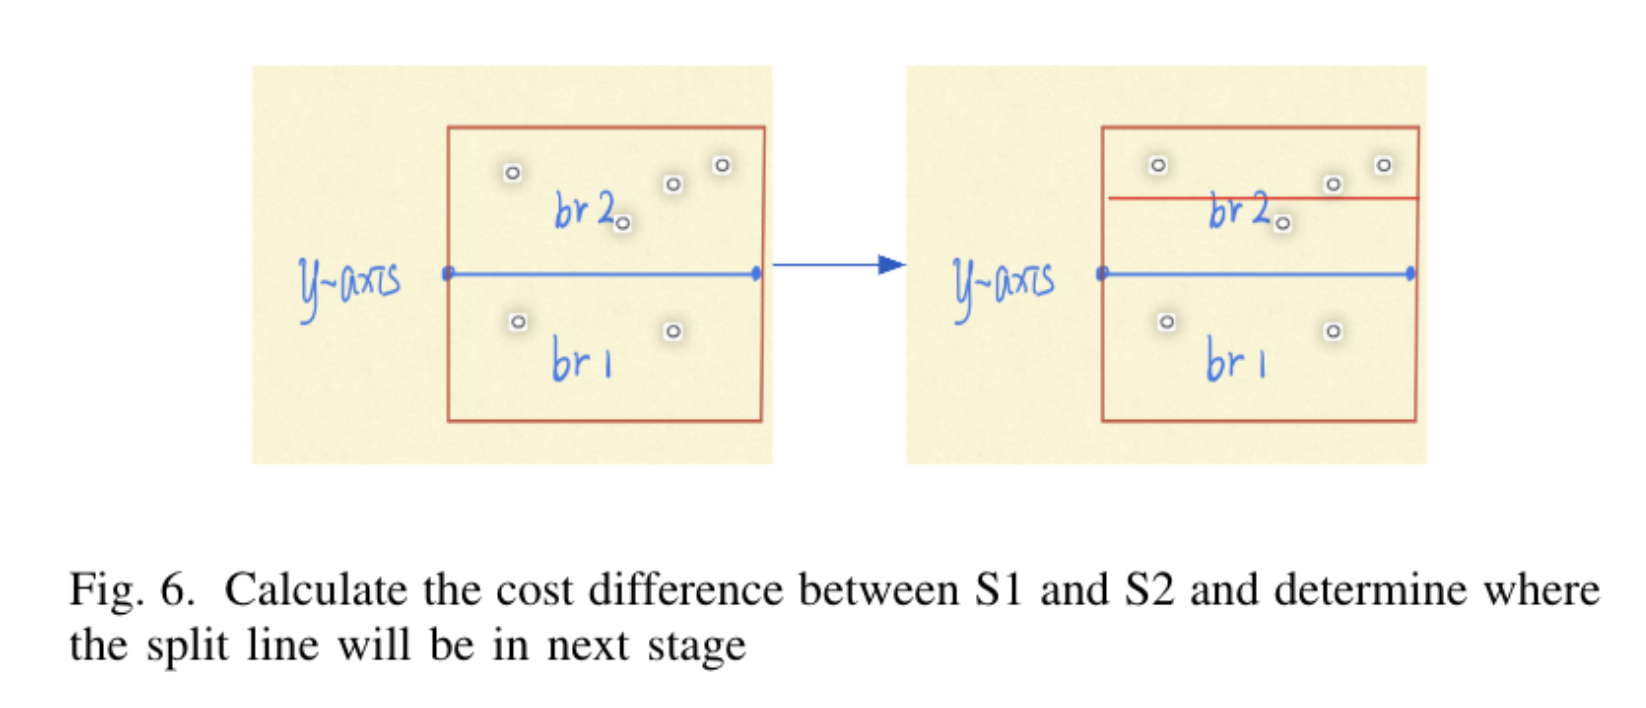

In [19]:
def _get_cost(bounds, nPoints, fanout=2):
    return nPoints


def cost_base_partition(rtree, maxCost, eps):
    mbr = rtree.bounds
    partition_list = []
    queue = deque()
    queue.append(mbr)
    while len(queue):
        br = queue.popleft()
        nPoints = rtree.count(br)
        if get_cost(br, nPoints) > maxCost:
            (subbr1, subbr2) = _cost_base_split(rtree, br, eps)
            queue.append(subbr1)
            queue.append(subbr2)
        else:
            partition_list.append(br)
    return partition_list


def _cost_base_split(rtree, bounds, eps):
    (xmin, ymin, xmax, ymax) = bounds
    #vertical split
    ymin_diff = float('inf')
    ysplit = ymin + (ymax - ymin) / 2
    ybest_split = ((xmin, ymin, xmax, ysplit), (xmin, ysplit, xmax, ymax))
    while (ysplit + eps * 2 <= ymax):
        lowerbr = (xmin, ymin, xmax, ysplit)
        lowercost = _get_cost(lowerbr, rtree.count(lowerbr))

        upperbr = (xmin, ysplit, xmax, ymax)
        uppercost = _get_cost(upperbr, rtree.count(upperbr))
        costdiff = abs(uppercost - lowercost)
        if costdiff < ymin_diff:
            ymin_diff = costdiff
            ybest_split = (lowerbr, upperbr)
            if uppercost < lowercost:
                ysplit = ymin + (ysplit - ymin) / 2
            else:
                ysplit = ysplit + (ymax - ysplit) / 2
        else:
            break

    #horizontal split
    xmin_diff = float('inf')
    xsplit = xmin + (xmax - xmin) / 2
    xbest_split = ((xmin, ymin, xsplit, ysplit), (xsplit, ymin, xmax, ymax))
    while (xsplit + eps * 2 <= xmax):
        lowerbr = (xmin, ymin, xsplit, ymax)
        lowercost = _get_cost(lowerbr, rtree.count(lowerbr))

        upperbr = (xsplit, ymin, xmax, ymax)
        uppercost = _get_cost(upperbr, rtree.count(upperbr))
        costdiff = abs(uppercost - lowercost)
        if costdiff < xmin_diff:
            xmin_diff = costdiff
            xbest_split = (lowerbr, upperbr)
            if uppercost < lowercost:
                xsplit = xmin + (xsplit - xmin) / 2
            else:
                xsplit = xsplit + (xmax - xsplit) / 2
        else:
            break

    #compare ysplit and xsplit
    if xmin_diff < ymin_diff:
        return xbest_split
    else:
        return ybest_split


#construct rtree index
def construct_rtree_index(dataset):
    p = index.Property()
    rtree_idx = index.Index(properties=p)
    count = 0
    for coordinate in dataset:
        rtree_idx.insert(count, (*coordinate, *coordinate))
        count += 1
    return rtree_idx


def cbs_fixnum(rtree, eps, n_partition):
    mbr = rtree.bounds
    partition_list = []
    queue = PriorityQueue()
    cost = _get_cost(mbr, rtree.count(mbr))
    queue.put((-cost, mbr))
    while queue.qsize() < n_partition:
        (score, br) = queue.get()
        subbrs = _cost_base_split(rtree, br, eps)
        for subbr in subbrs:
            cost = _get_cost(subbr, rtree.count(subbr))
            queue.put((-cost, subbr))
    while queue.qsize() > 0:
        (score, br) = queue.get()
        partition_list.append(br)
    return partition_list

@timeit
def rtree_partition(dataset, n_patitions, eps, mtd='cbs'):
    """
    params:parameters needed for different spliting method; for cost-base method params=('cbs', max_cost);
    for reduced-boundary method params = ('rbs', max_points)
    """
    idx = construct_rtree_index(dataset)
    # split test
    if mtd == 'cbs':
        partitioned = cbs_fixnum(idx, eps, n_patitions)
    else:
        partitioned = rbs_fixnum(idx, eps, n_patitions)

    indexed_data = []
    id_ptt = 0
    for boundary in partitioned:
        (left, bot, right, top) = boundary
        for id_pts in idx.intersection(
            (left - eps, bot - eps, right + eps, top + eps)):
            indexed_data.append([id_ptt, id_pts])
        id_ptt += 1

    res = sc.parallelize(
        indexed_data).groupByKey().map(lambda x: [x[0], list(x[1])])
    return res


### Entry Functions

In [20]:
def partition(dataset, eps, partition_tuple, rtree=False, rtree_mtd='cbs'):
    if rtree:
        partition_tuple = np.prod(partition_tuple)
        partitioned_rdd = rtree_partition(dataset,
                                          partition_tuple,
                                          eps,
                                          mtd=rtree_mtd)
    else:
        partitioned_rdd = spatial_partition(dataset, partition_tuple, eps)
    return partitioned_rdd


# parallel entry function
@timeit
def parallel_dbscan(dataset,
                    eps,
                    min_pts,
                    partition_tuple,
                    method='matrix',
                    metric='euclidian',
                    rtree=False,
                    rtree_mtd='cbs',
                    verbose=False):

    partitioned_rdd = partition(dataset,
                                eps,
                                partition_tuple,
                                rtree=rtree,
                                rtree_mtd=rtree_mtd)
    local_tags = partitioned_rdd.mapValues(lambda x: local_dbscan(
        x, method=method, metric=metric)).collect()
    result_tags = merge(local_tags, dataset)
    
    if verbose:
        p = partitioned_rdd.collect()
        print('Partition info:')
        for i in range(len(p)):
            print('partition ', p[i][0],
                  ', num of points: ', len(p[i][1]),
                  ', num of clusters: ', len(np.unique(np.array(local_tags[i][-1])[:, 1])))
        print('Number of Clusters:')

    return result_tags


## Plot Module

### Parallel Experiment

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib notebook

def plot_result(dataset, result_tags, file_name=None, style='ticks'):
    # data preparation
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags
    
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, sharex=True, sharey=True)
    
    sns.scatterplot('x', 'y',data=df, ax=axes[0], palette='Blues_d')
    sns.scatterplot('x', 'y', data=df, hue='label', ax=axes[1])
    
    plt.title(f'DBSCAN Result of {file_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.gca().get_legend().set_visible(False)

    plt.tight_layout()
    plt.show()

In [22]:
test_file = 'jain_373.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 1), [2, 2], [2, 4],[3,4]]
eps = 2
min_pts = 18
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    print('\nRtree-cbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='cbs')


Partitions: 2

Rtree-cbs:
rtree_partition time cost: 31.071186065673828ms
merge time cost: 2.245187759399414ms
parallel_dbscan time cost: 486.2818717956543ms

Partitions: 4

Rtree-cbs:
rtree_partition time cost: 26.829004287719727ms
merge time cost: 3.448963165283203ms
parallel_dbscan time cost: 291.80216789245605ms

Partitions: 8

Rtree-cbs:
rtree_partition time cost: 31.948089599609375ms
merge time cost: 4.589080810546875ms
parallel_dbscan time cost: 184.17787551879883ms

Partitions: 12

Rtree-cbs:
rtree_partition time cost: 34.07883644104004ms
merge time cost: 5.465269088745117ms
parallel_dbscan time cost: 210.32238006591797ms


predict time cost: 795.57204246521ms
Number of clusters: 8


<IPython.core.display.Javascript object>


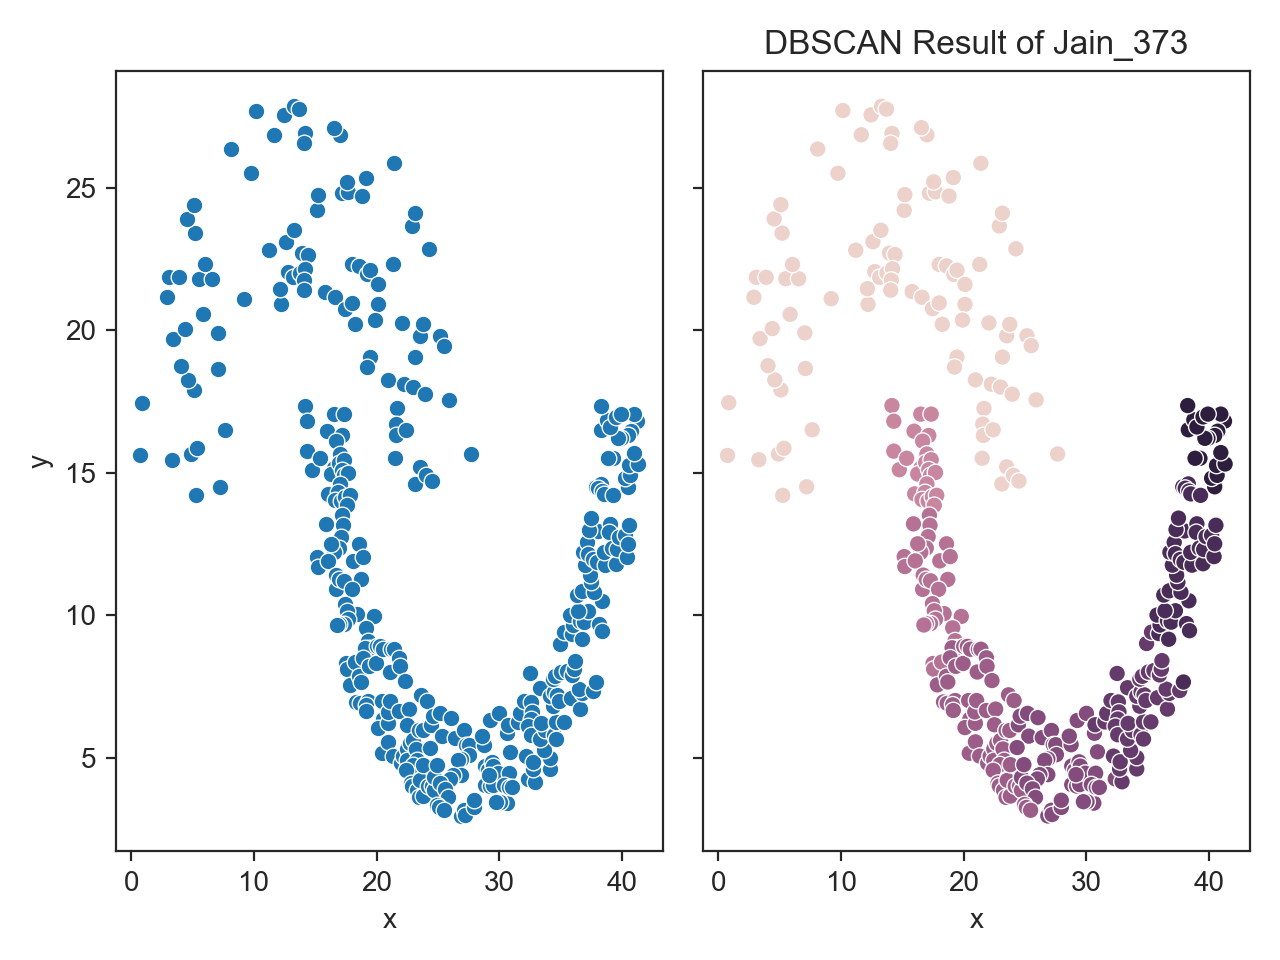

eps: 3 min points: 18 silhouette coefficient: 0.30428701469580155


/Users/xingzhenghao/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/xingzhenghao/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.30428701469580155

In [23]:
test_file = '2.dataset/jain_373.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [4, 4], [4, 8]]
eps = 3
min_pts = 18
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
print('Number of clusters:', len(np.unique(np.array(result_tags))))
plot_result(dataset, result_tags, 'Jain_373')
Evaluation.silhouette_coefficient(mdbscan)
